In [ ]:
#Author: Yadi Deng, Haoran Zhang

In [1]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting
import pandas as pd
import os
from os import listdir
from os.path import isfile, join, isdir

In [13]:
array = np.load('train_data_56_260_1_40Hz.npy') 
array.shape

(16, 340, 56, 260)

In [14]:
arrayT = np.load('test_data_56_260_1_40Hz.npy') 
arrayT.shape

(10, 340, 56, 260)

In [16]:
label = pd.read_csv('./data/TrainLabels.csv') # put your train label path here
y = label['Prediction'].values
print(y.shape)

(5440,)


In [17]:
labelT = pd.read_csv('./data/true_labels.csv', header = None) # put your train label path here
print(labelT.shape)
yT = np.array(labelT).reshape(3400,)
print(yT.shape)

(3400, 1)
(3400,)


In [18]:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

XC = XdawnCovariances(nfilter=5)
output = XC.fit_transform(np.reshape(array, (16*340, 56, 260)), y)
output = TangentSpace(metric='riemann').fit_transform(output)
output.shape

(5440, 210)

In [19]:

outputT = XC.fit_transform(np.reshape(arrayT, (10*340, 56, 260)), yT)
outputT = TangentSpace(metric='riemann').fit_transform(outputT)
outputT.shape

(3400, 210)

In [20]:
X = np.reshape(output, (16, 340, 210))
data_train = X[:10]
data_test = X[-6:]
print(data_train.shape, data_test.shape)

(10, 340, 210) (6, 340, 210)


In [21]:
# data split
y_train, y_test = np.array([]), np.array([])
y_train = y

y_test = yT

X_train = output

X_test = outputT

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5440, 210) (5440,) (3400, 210) (3400,)


## LDA

## Logistic Regression

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/Applications/conda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
y_pred = logreg.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55       989
           1       0.81      0.86      0.84      2411

   micro avg       0.76      0.76      0.76      3400
   macro avg       0.71      0.68      0.69      3400
weighted avg       0.75      0.76      0.75      3400



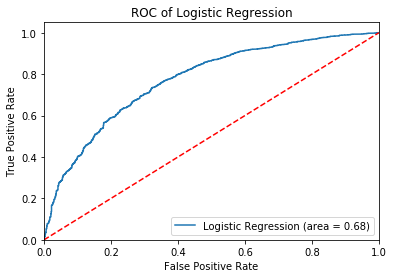

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## SVM

In [28]:
##SVM import packages
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import KFold
####SVm with linear
###C list as [1,10]
###leave 4 groups out
clSvm = SVC(kernel = 'linear') 
p = {'kernel':('linear',), 'C':[0.001,0.1,1,10]}
clSvm= GridSearchCV(clSvm, p,cv = KFold(4))
clSvm.fit(X_train, y_train )
y_hat_Svm = clSvm.predict(X_test)
print('ACC:'+ "{0:.3f}".format(accuracy_score(y_test, y_hat_Svm)))
print('AUC:'+"{0:.3f}".format(roc_auc_score(y_test, y_hat_Svm)))
##With kerneal as rbf
###C list as [1,10]
###leave 4 groups out
clSvm = SVC(kernel = 'rbf',gamma="scale") 
parameters = {'kernel':('rbf',), 'C':[0.001,0.1,1,10]}
clSvm= GridSearchCV(clSvm, parameters,cv = KFold(4))
clSvm.fit(X_train, y_train)
y_hat_Svm = clSvm.predict(X_test)
print('ACC:'+ "{0:.3f}".format(accuracy_score(y_test, y_hat_Svm)))
print('AUC:'+"{0:.3f}".format(roc_auc_score(y_test, y_hat_Svm)))
#With kerneal as sigmoid
###C list as [1,10]
###leave 4 groups out
clSvm = SVC(kernel = 'sigmoid',gamma="scale") 
parameters = {'kernel':('sigmoid',), 'C':[0.001,0.1,1,10]}
clSvm= GridSearchCV(clSvm, parameters,cv =KFold(4))
clSvm.fit(X_train, y_train)
y_hat_Svm = clSvm.predict(X_test)
print('ACC:'+ "{0:.3f}".format(accuracy_score(y_test, y_hat_Svm)))
print('AUC:'+"{0:.3f}".format(roc_auc_score(y_test, y_hat_Svm)))

ACC:0.757
AUC:0.673
ACC:0.754
AUC:0.651
ACC:0.742
AUC:0.663


## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
clf_tree = DecisionTreeClassifier()
parameters = {
    'min_samples_split' : range(10,500,20),
    'max_depth': range(1,20,2)
}
dt = GridSearchCV(clf_tree, param_grid = parameters, cv = 4)
dt.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
dt.best_params_

{'max_depth': 1, 'min_samples_split': 10}

In [31]:
dtc = DecisionTreeClassifier(max_depth = 1, min_samples_split = 10)
dtc.fit(X_train,y_train)
y_pred_d = dtc.predict(X_test)
print('ACC of Decision Tree classifier on test set:'+ "{0:.3f}".format(accuracy_score(y_test, y_pred_d)))
print('AUC of Decision Tree classifier on test set:'+"{0:.3f}".format(roc_auc_score(y_test, y_pred_d)))

ACC of Decision Tree classifier on test set:0.709
AUC of Decision Tree classifier on test set:0.500


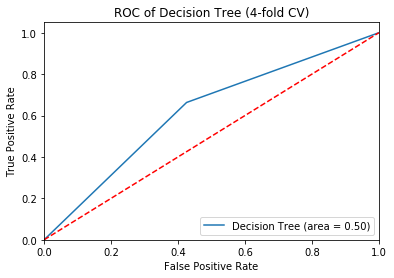

In [43]:
dt_roc_auc = roc_auc_score(y_test, y_pred_d)
fpr, tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Decision Tree (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

In [33]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
y_pred_dt = dtc.predict(X_test)
print('ACC of Decision Tree classifier on test set:'+ "{0:.3f}".format(accuracy_score(y_test, y_pred_dt)))
print('AUC of Decision Tree classifier on test set:'+"{0:.3f}".format(roc_auc_score(y_test, y_pred_dt)))

ACC of Decision Tree classifier on test set:0.709
AUC of Decision Tree classifier on test set:0.500


## Random Forest

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.2s
/Applications/conda/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  2.0min finished


{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'n_estimators': 1000}

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 1000,
 max_features = 3,
 max_depth = 80,
 bootstrap = True)
rf_clf.fit(X_train,y_train)
y_pred_r = rf_clf.predict(X_test)

print('ACC of Randomforest classifier on test set:'+ "{0:.3f}".format(accuracy_score(y_test, y_pred_r)))
print('AUC of Randomforest classifier on test set:'+"{0:.3f}".format(roc_auc_score(y_test, y_pred_r)))

ACC of Randomforest classifier on test set:0.710
AUC of Randomforest classifier on test set:0.501


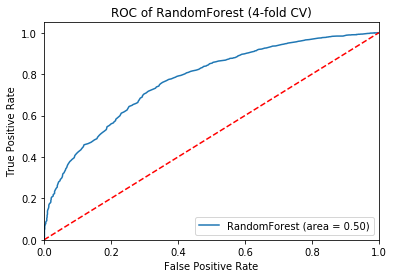

In [36]:
r_roc_auc = roc_auc_score(y_test, y_pred_r)
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('Randomforest_ROC')
plt.show()

In [37]:
log = logreg.predict_proba(X_test)[:,1]
np.save('log_labels.npy', log)

In [38]:
rf_ = rf_clf.predict_proba(X_test)[:,1]
np.save('rf_labels.npy', rf_)

In [39]:
np.load('log_labels.npy')

array([0.89026036, 0.52760977, 0.31320542, ..., 0.57374461, 0.92613669,
       0.96021799])

In [40]:
dt = dtc.predict_proba(X_test)[:,1]
np.save('dt_labels.npy', dt)

In [41]:
np.load('dt_labels.npy')

array([0.78886756, 0.78886756, 0.59809853, ..., 0.59809853, 0.59809853,
       0.78886756])